# Facies classification

The following notebook explores the possibility to predict rock facies in well-log data using ML algorithms. 

Data in this notebook comes from [link](http://www.people.ku.edu/~gbohling/EECS833/) and is well log data from North America, the Hugoton and Panoma Fields. 

There was also a Geophysics ML contest in 2016 analysing this same data set, the results can be found in [The Leading Edge](https://library.seg.org/doi/abs/10.1190/tle35100906.1) written by Brendon Hall. 

The dataset consists of 5 wireline log measurements, two indicator variables and a facies label at half foot intervals. In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
mpl.rcParams['figure.figsize']=(20.0,10.0)
inline_rc = dict(mpl.rcParams)
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Raw Data Exploration

In [22]:
Well_Data = pd.read_csv("facies_vectors.csv")

In [23]:
print(Well_Data.shape)
Well_Data.head()

(4149, 11)


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


This data is from the Council Grove gas reservoir in Southwest Kansas. The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas. This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector. Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate.

Five wire line log curves include gamma ray (GR), resistivity logging (ILD_log10), photoelectric effect (PE), neutron-density porosity difference and average neutron-density porosity (DeltaPHI and PHIND). Note, some wells do not have PE.
Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

In [24]:
print("Wells in the dataset", Well_Data['Well Name'].unique())
print("Number of formation is" , Well_Data['Formation'].nunique())
print("Formations are" , Well_Data['Formation'].unique())

Wells in the dataset ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE'
 'NOLAN' 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']
Number of formation is 14
Formations are ['A1 SH' 'A1 LM' 'B1 SH' 'B1 LM' 'B2 SH' 'B2 LM' 'B3 SH' 'B3 LM' 'B4 SH'
 'B4 LM' 'B5 SH' 'B5 LM' 'C SH' 'C LM']


In [25]:
# Converts to category
Well_Data['Well Name'].unique()

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE'], dtype=object)

In [26]:
Well_Data.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'],
      dtype='object')

In [27]:
# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [28]:
# Store features and labels
X = Well_Data[feature_names].values  # features
y = Well_Data['Facies'].values  # labels

In [29]:
well = Well_Data['Well Name'].values
depth = Well_Data['Depth'].values

## Visualize the data

#### Define function for plotting feature statistics

In [30]:
def plot_feature_stats(X, y, feature_names, facies_colors, facies_names):
    
    # Remove NaN
    nan_idx = np.any(np.isnan(X), axis=1)
    X = X[np.logical_not(nan_idx), :]
    y = y[np.logical_not(nan_idx)]
    
    # Merge features and labels into a single DataFrame
    features = pd.DataFrame(X, columns=feature_names)
    labels = pd.DataFrame(y, columns=['Facies'])
    for f_idx, facies in enumerate(facies_names):
        labels[labels[:] == f_idx] = facies
    data = pd.concat((labels, features), axis=1)

    # Plot features statistics
    facies_color_map = {}
    for ind, label in enumerate(facies_names):
        facies_color_map[label] = facies_colors[ind]

    sns.pairplot(data, hue='Facies', palette=facies_color_map, hue_order=list(reversed(facies_names)))

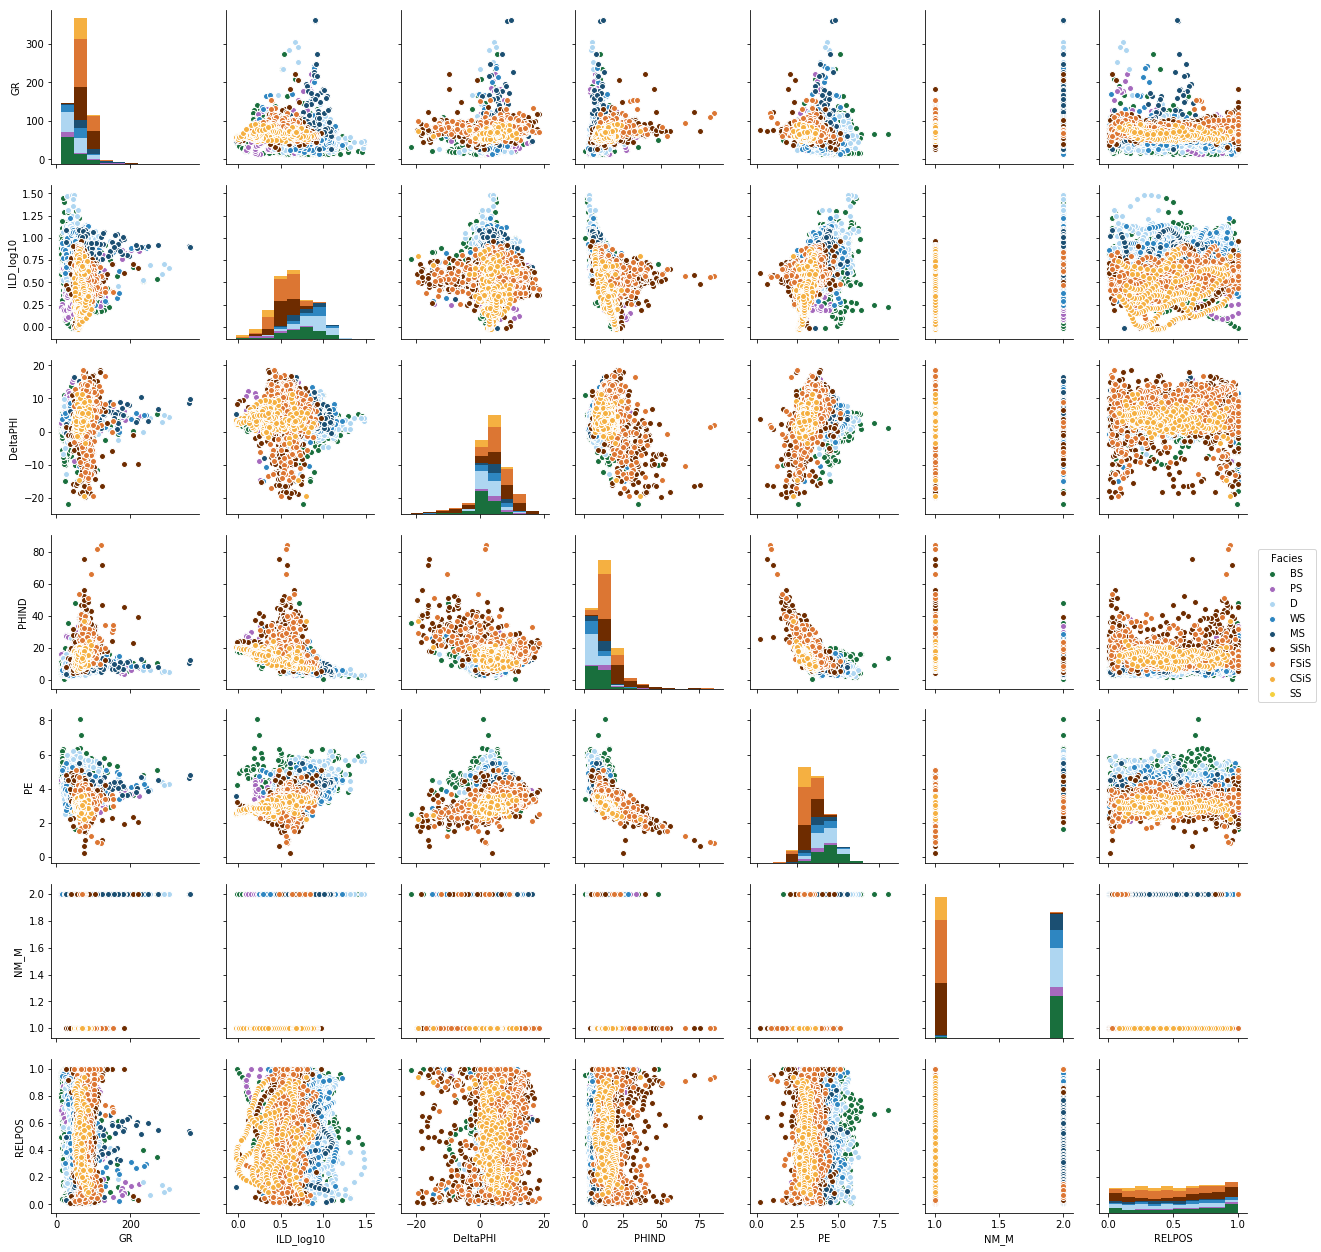

In [31]:
# Feature distribution
plot_feature_stats(X, y, feature_names, facies_colors, facies_names)
mpl.rcParams.update(inline_rc)

Observations:

- Some features seem to be affected by a few outlier measurements.
- Only a few wells contain samples from all classes.
- PE measurements are available only for some wells.

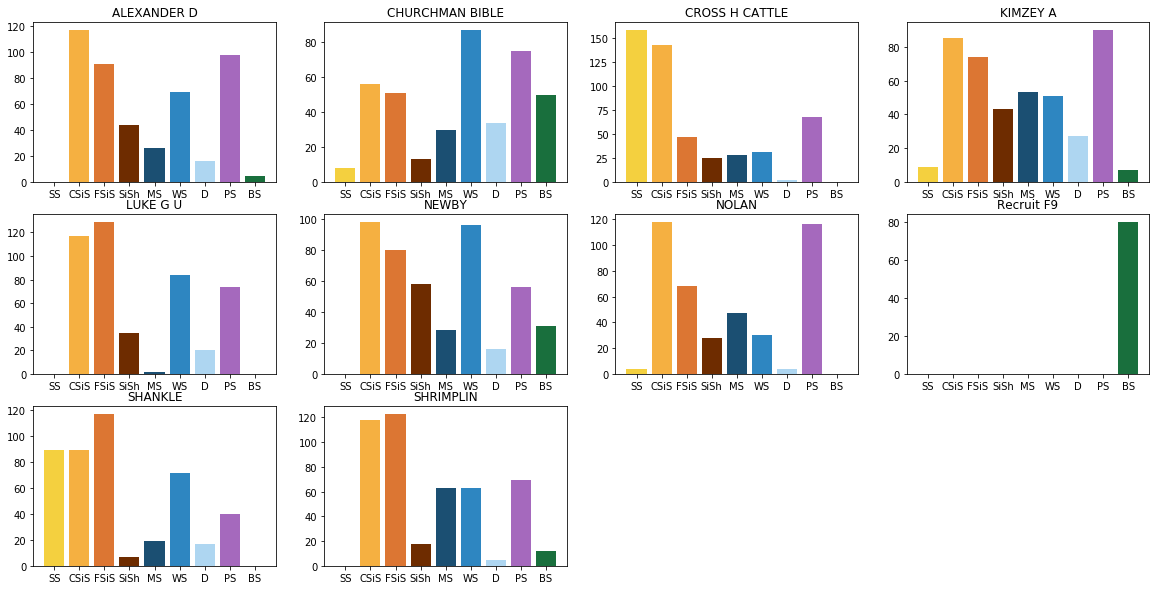

In [32]:
# Facies per well
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.histogram(y[well == w], bins=np.arange(len(facies_names)+1)+.5)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_names)
    ax.set_title(w)

SS      268
CSiS    940
FSiS    780
SiSh    271
MS      296
WS      582
D       141
PS      686
BS      185
Name: Facies, dtype: int64

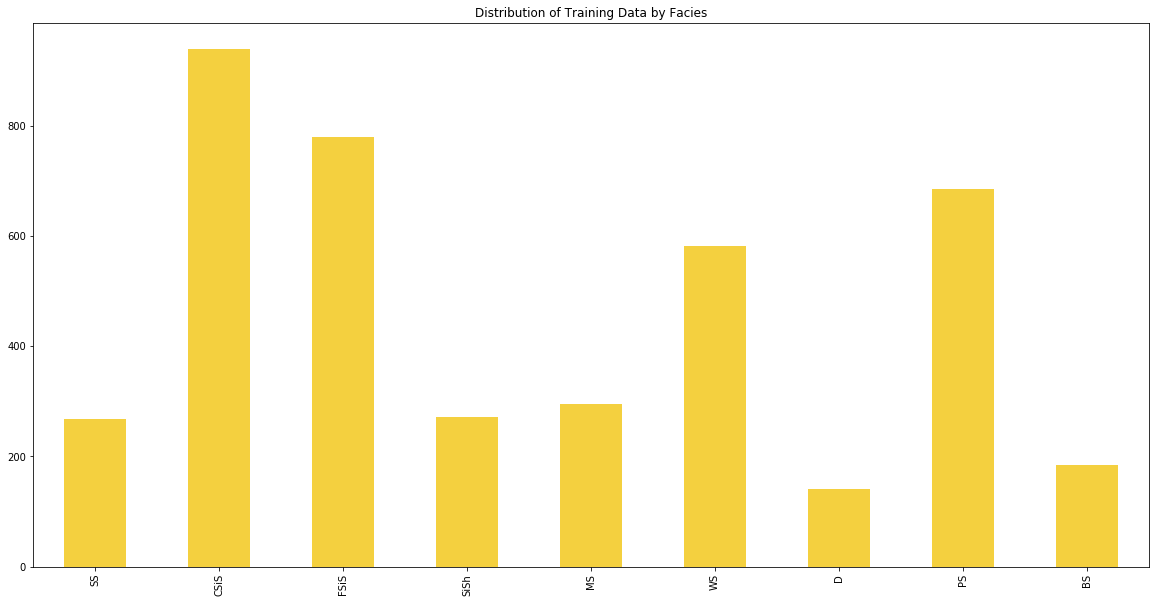

In [36]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = Well_Data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_names

facies_counts.plot(kind='bar',color=facies_colors, title='Distribution of Training Data by Facies')
facies_counts

In [41]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

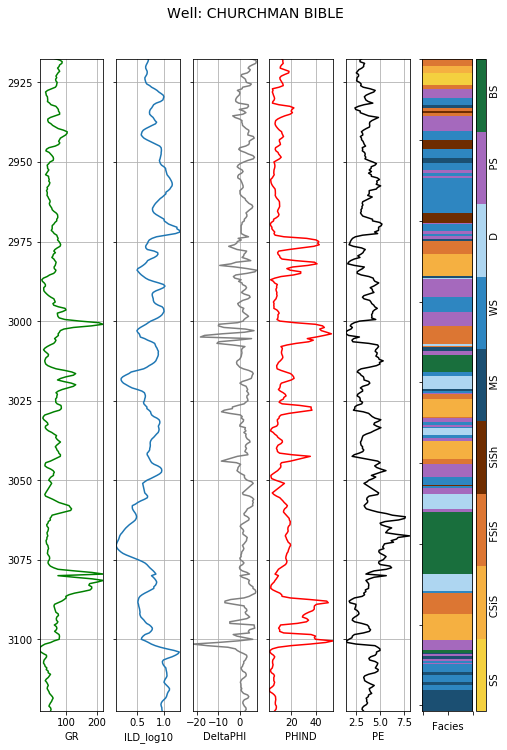

In [42]:
make_facies_log_plot(Well_Data[Well_Data['Well Name'] == 'CHURCHMAN BIBLE'],facies_colors)

#make_facies_log_plot(Well_Data[Well_Data['Well Name'] == 'NOLAN'],facies_colors)

### Missing PE values

In [43]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [44]:
reg = RandomForestRegressor(max_features='sqrt', n_estimators=50)
DataImpAll = Well_Data[feature_names].copy()
DataImp = DataImpAll.dropna(axis = 0, inplace=False)
Ximp=DataImp.loc[:, DataImp.columns != 'PE']
Yimp=DataImp.loc[:, 'PE']
reg.fit(Ximp, Yimp)
X[np.array(DataImpAll.PE.isnull()),4] = reg.predict(DataImpAll.loc[DataImpAll.PE.isnull(),:]
                                                    .drop('PE',axis=1,inplace=False))

### Feature engineering

In [45]:
# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

In [46]:
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [47]:
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

In [48]:
X, padded_rows = augment_features(X, well, depth)

In [49]:
from sklearn import preprocessing
scaler = preprocessing.RobustScaler().fit(X)
X = scaler.transform(X)

## Make SVC classifier

### Split data

In [50]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=101)

/Users/elliotdahl/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Train classifier

In [51]:
from sklearn import svm
clf = svm.SVC()

In [52]:
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
predicted_labels = clf.predict(X_test)

In [54]:
from sklearn.metrics import classification_report,confusion_matrix

conf = confusion_matrix(y_test, predicted_labels)
print(conf)
print(classification_report(y_test,predicted_labels))

[[ 28  25   0   0   0   0   0   0   0]
 [  6 143  33   0   0   0   0   2   0]
 [  2  51 101   1   0   0   0   4   0]
 [  0   0   0  43   0   8   1   5   0]
 [  0   2   4   6   2  28   0  13   0]
 [  0   0   1  14   0  65   0  34   1]
 [  0   0   1   4   0   2  25   5   0]
 [  0   0   3   6   2  20   4  89   8]
 [  0   0   0   0   0   2   1  11  24]]
             precision    recall  f1-score   support

          1       0.78      0.53      0.63        53
          2       0.65      0.78      0.71       184
          3       0.71      0.64      0.67       159
          4       0.58      0.75      0.66        57
          5       0.50      0.04      0.07        55
          6       0.52      0.57      0.54       115
          7       0.81      0.68      0.74        37
          8       0.55      0.67      0.60       132
          9       0.73      0.63      0.68        38

avg / total       0.63      0.63      0.61       830



Array above is classified by SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS


The rows of the confusion matrix correspond to the actual facies labels. The columns correspond to the labels assigned by the classifier. For example, consider the first row. For the feature vectors in the test set that actually have label SS, 27 were correctly indentified as SS and 26 were classified as CSiS.

In [55]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [56]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]]) #see link (top) for explanation

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [57]:
print('Facies classification accuracy = {}'.format(accuracy(conf)))
print('Adjacent facies classification accuracy = {}'.format(accuracy_adjacent(conf, adjacent_facies)))

Facies classification accuracy = 0.6265060240963856
Adjacent facies classification accuracy = 0.908433734939759


### Optimize the C and gamma parameters through a grid search

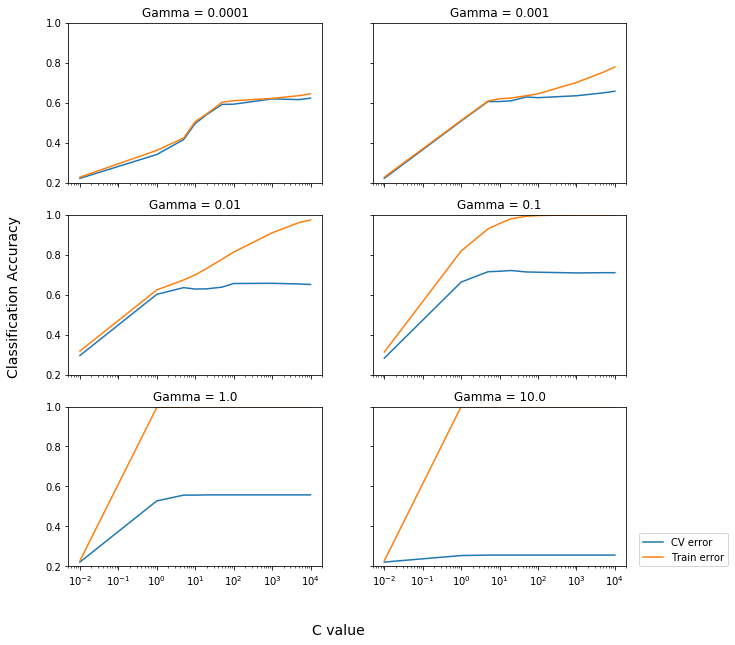

In [58]:

if True:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = plot_number // 2
        column = plot_number % 2
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C = c_value, gamma = gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)
            
        ax = axes[row, column]
        ax.set_title('Gamma = {}'.format(gamma_value))
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', rotation='vertical', fontsize=14)

The best accuracy on the cross validation error curve was achieved for gamma = 0.1, and C = 10.

In [59]:
clf = svm.SVC(C = 10, gamma = 0.1)        
clf.fit(X_train,y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print('Optimized facies classification accuracy = {}'.format(accuracy(cv_conf)))
print('Optimized adjacent facies classification accuracy = {}'.format(accuracy_adjacent(cv_conf, adjacent_facies)))

Optimized facies classification accuracy = 0.7168674698795181
Optimized adjacent facies classification accuracy = 0.9156626506024096


In [60]:
print(confusion_matrix(y_test, predicted_labels))
print(classification_report(y_test,predicted_labels))

[[ 28  25   0   0   0   0   0   0   0]
 [  6 143  33   0   0   0   0   2   0]
 [  2  51 101   1   0   0   0   4   0]
 [  0   0   0  43   0   8   1   5   0]
 [  0   2   4   6   2  28   0  13   0]
 [  0   0   1  14   0  65   0  34   1]
 [  0   0   1   4   0   2  25   5   0]
 [  0   0   3   6   2  20   4  89   8]
 [  0   0   0   0   0   2   1  11  24]]
             precision    recall  f1-score   support

          1       0.78      0.53      0.63        53
          2       0.65      0.78      0.71       184
          3       0.71      0.64      0.67       159
          4       0.58      0.75      0.66        57
          5       0.50      0.04      0.07        55
          6       0.52      0.57      0.54       115
          7       0.81      0.68      0.74        37
          8       0.55      0.67      0.60       132
          9       0.73      0.63      0.68        38

avg / total       0.63      0.63      0.61       830



Array above is classified by SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS

## Make Random forrest classifier

In [61]:
from sklearn.model_selection import LeaveOneGroupOut
logo = LeaveOneGroupOut()

In [83]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

In [108]:
import warnings
warnings.filterwarnings('ignore')

In [109]:

f1s_ls = []
acc_ls = []
adj_ls = []

for train, test in logo.split(X, y, groups=well):
    
    well_name = well[test[0]]
    X_tr = X[train]
    X_te = X[test]

    Y_tr = y[train]
    
    RFC = RandomForestClassifier(n_estimators=200, min_samples_split=20, min_samples_leaf=10,
                                 class_weight='balanced', criterion='entropy', max_features=10, 
                                 random_state=7)
    RFC.fit(X_tr, Y_tr)
    y_pred = RFC.predict(X_te)
    
    #score
    try:
        f1s = f1_score(y[test], y_pred, average="weighted", labels=[0, 1, 2, 3, 4, 5, 6, 7, 8]);
    except:
        f1s = 0
    
    try:
        conf = confusion_matrix(y[test], y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
        acc = accuracy(conf)
    except:
        acc = 0
    
    try:
        acc_adj = accuracy_adjacent(conf,adjacent_facies)
    except:
        acc_adj = 0
        
    f1s_ls += [f1s]
    acc_ls += [acc]
    adj_ls += [acc_adj]
    
    print("{:>20s} f1:{:.3f} | acc:{:.3f} | acc_adj:{:.3f}".format(well_name, f1s, acc, acc_adj))

print("Avg F1", np.average(f1s_ls)*100, "Avg Acc", np.average(acc_ls)*100, 
      "Avg AccAdj", np.average(adj_ls)*100)
    
    

         ALEXANDER D f1:0.528 | acc:0.564 | acc_adj:0.709
     CHURCHMAN BIBLE f1:0.565 | acc:0.578 | acc_adj:0.796
      CROSS H CATTLE f1:0.441 | acc:0.431 | acc_adj:0.729
            KIMZEY A f1:0.517 | acc:0.553 | acc_adj:0.744
            LUKE G U f1:0.622 | acc:0.591 | acc_adj:0.758
               NEWBY f1:0.550 | acc:0.577 | acc_adj:0.712
               NOLAN f1:0.575 | acc:0.602 | acc_adj:0.790
          Recruit F9 f1:0.000 | acc:0.000 | acc_adj:0.790
             SHANKLE f1:0.620 | acc:0.612 | acc_adj:0.840
           SHRIMPLIN f1:0.501 | acc:0.529 | acc_adj:0.660
Avg F1 49.1899724906 Avg Acc 50.3799735429 Avg AccAdj 75.2725976518


# Comparison

In [112]:
#SVC
print('SVC:')
print('Optimized facies classification accuracy = {}'.format(accuracy(cv_conf)))
print('Optimized adjacent facies classification accuracy = {}'.format(accuracy_adjacent(cv_conf, adjacent_facies)))

SVC:
Optimized facies classification accuracy = 0.7168674698795181
Optimized adjacent facies classification accuracy = 0.9156626506024096


In [113]:
#RFC
RFC = RandomForestClassifier(n_estimators=200, min_samples_split=20, min_samples_leaf=10,
                                 class_weight='balanced', criterion='entropy', max_features=10, 
                                 random_state=7)        
RFC.fit(X_train,y_train)

cv_r_conf = confusion_matrix(y_test, RFC.predict(X_test))
print('RFC:')
print('Optimized facies classification accuracy = {}'.format(accuracy(cv_r_conf)))
print('Optimized adjacent facies classification accuracy = {}'.format(accuracy_adjacent(cv_r_conf, adjacent_facies)))

RFC:
Optimized facies classification accuracy = 0.7144578313253012
Optimized adjacent facies classification accuracy = 0.9168674698795181


Both SVC and RFC does very similar in terms of accuarcy on the test set above